#### Set up Dataset - A binary subset of CIFAR 10

In [4]:
import tensorflow as tf
from jinja2.optimizer import optimize
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Create a binary subset for classes 'cat' (label 3) and 'dog' (label 5)
binary_classes = [3, 5]
train_filter = np.isin(y_train, binary_classes).reshape(-1)
test_filter = np.isin(y_test, binary_classes).reshape(-1)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Map labels to binary (0 and 1)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Split the training data into training and validation sets (80% train, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Resize images to match input size for pretrained models (224x224)
IMG_SIZE = (224, 224)

# Resizing function for CIFAR-10 images
def preprocess_images(images):
    return np.array([tf.image.resize(image, IMG_SIZE).numpy() for image in images])

x_train_resized = preprocess_images(x_train)
x_val_resized = preprocess_images(x_val)
x_test_resized = preprocess_images(x_test)

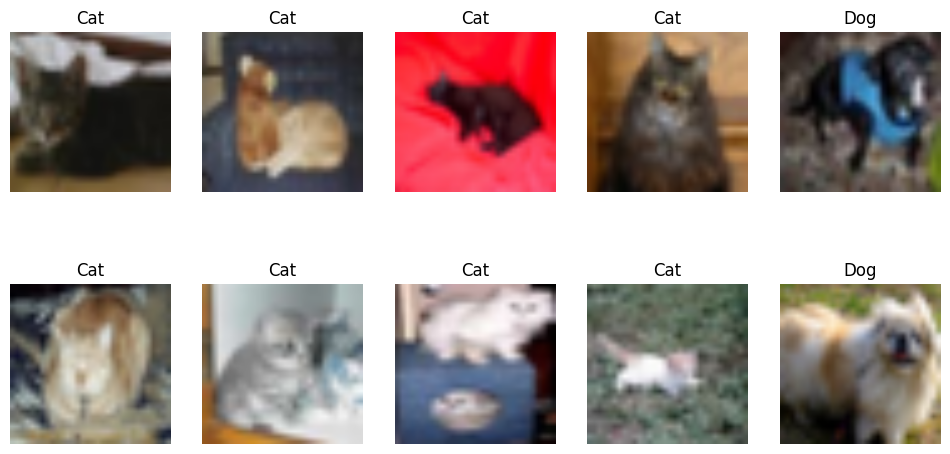

In [6]:
# Define class names for display
class_names = ["Cat", "Dog"]

# Function to display sample images
def display_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(class_names[labels[i][0]])
        plt.axis("off")
    plt.show()

# Display 10 sample images from the resized training dataset
display_sample_images(x_train_resized, y_train, class_names, num_images=10)


In [7]:
x_train_resized.shape

(10000, 224, 224, 3)

#### Preprocessing and Augmentation

In [45]:
# Data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow(x_train_resized, y_train, batch_size=16)
val_gen = val_datagen.flow(x_val_resized, y_val, batch_size=16)
test_gen = val_datagen.flow(x_test_resized, y_test, batch_size=16)


#### Creating Models
* DenseNet121
* VGG16
* NASNetMobile

In [6]:
from tensorflow.keras.applications import DenseNet121, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile

def create_model(base_model_class, input_shape=(224, 224, 3)):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Initialize models
densenet_model = create_model(DenseNet121)
vgg_model = create_model(VGG16)
nasnet_model = create_model(NASNetMobile)

#### Define Validation Set and all Models

In [48]:
# Danger cell
epochs = 10
learning_rate = 1e-4
patience = 5

# Updated compile_and_train function to use val_gen
def compile_and_train(model, train_gen, val_gen, epochs, learning_rate, model_name):
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', monitor='val_accuracy', save_best_only=True)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])
    return history

In [9]:
print('\n\nDenseNet Training Now...........\n\n')
densenet_history = compile_and_train(densenet_model, train_gen, val_gen, epochs, learning_rate, 'DenseNet121')




DenseNet Training Now...........


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.6814 - loss: 0.5921 - recall: 0.6862 - val_accuracy: 0.7565 - val_loss: 0.5076 - val_recall: 0.7472
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.7613 - loss: 0.4973 - recall: 0.7247 - val_accuracy: 0.7850 - val_loss: 0.4628 - val_recall: 0.7884
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.7796 - loss: 0.4723 - recall: 0.7359 - val_accuracy: 0.8020 - val_loss: 0.4379 - val_recall: 0.8024
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.7917 - loss: 0.4442 - recall: 0.7463 - val_accuracy: 0.8080 - val_loss: 0.4240 - val_recall: 0.8164
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.7972 - loss: 0.4341 - recall: 0.7529 - val_accuracy: 0.8170 - val_loss: 0.4095 - val_recall: 0.8084
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.7943 - loss: 0.4286 - recall: 0.7500 - val_accuracy: 0.

In [12]:
densenet_model.evaluate(val_gen)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8172 - loss: 0.3885 - recall: 0.8063


[0.37801358103752136, 0.8259999752044678, 0.8144433498382568]

In [11]:
print('\n\nNASNet Training Now...........\n\n')
nasnet_history = compile_and_train(nasnet_model, train_gen, val_gen, epochs, learning_rate, 'NASNetMobile')



NASNet Training Now...........


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.6148 - loss: 0.6561 - recall: 0.7390 - val_accuracy: 0.8000 - val_loss: 0.4692 - val_recall: 0.7513
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.7960 - loss: 0.4675 - recall: 0.7619 - val_accuracy: 0.8205 - val_loss: 0.4061 - val_recall: 0.8074
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8147 - loss: 0.4271 - recall: 0.7760 - val_accuracy: 0.8325 - val_loss: 0.3775 - val_recall: 0.8205
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8157 - loss: 0.4036 - recall: 0.7781 - val_accuracy: 0.8335 - val_loss: 0.3631 - val_recall: 0.8295
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8241 - loss: 0.3900 - recall: 0.7841 - val_accuracy: 0.8340 - val_loss: 0.3575 - val_recall: 0.8586
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.8248 - loss: 0.3835 - recall: 0.7951 - val_accuracy: 0.83

In [13]:
nasnet_model.evaluate(val_gen)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8587 - loss: 0.3333 - recall: 0.8360


[0.3271901607513428, 0.8535000085830688, 0.8375125527381897]

In [49]:
vgg_history = compile_and_train(vgg_model, train_gen, val_gen, epochs, learning_rate, 'VGG16')

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.6295 - loss: 0.6673 - recall: 0.6078 - val_accuracy: 0.6350 - val_loss: 0.6674 - val_recall: 0.7553
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.6440 - loss: 0.6643 - recall: 0.6230 - val_accuracy: 0.6335 - val_loss: 0.6658 - val_recall: 0.7633
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.6356 - loss: 0.6626 - recall: 0.6449 - val_accuracy: 0.6315 - val_loss: 0.6637 - val_recall: 0.6961
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.6406 - loss: 0.6612 - recall: 0.5835 - val_accuracy: 0.6330 - val_loss: 0.6631 - val_recall: 0.7934
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.6306 - loss: 0.6604 - recall: 0.5977 - val_accuracy: 0.6340 - val_loss: 0.6608 - val_recall: 0.7392
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.6400 - loss: 0.6588 - recall: 0.6429 - val_accuracy: 0.6370 - val_loss: 0.6592 - val_recall:

In [18]:
vgg_model.evaluate(val_gen)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6277 - loss: 0.6682 - recall: 0.7457


[0.6693769097328186, 0.6299999952316284, 0.7622868418693542]

#### Learning Curves

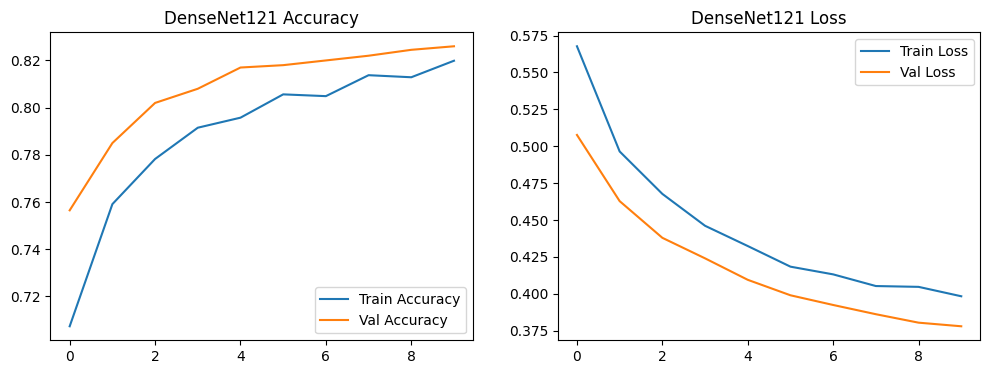

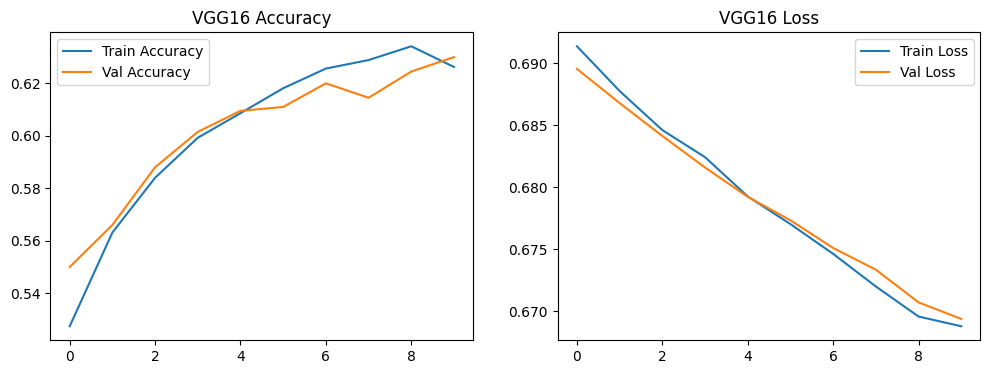

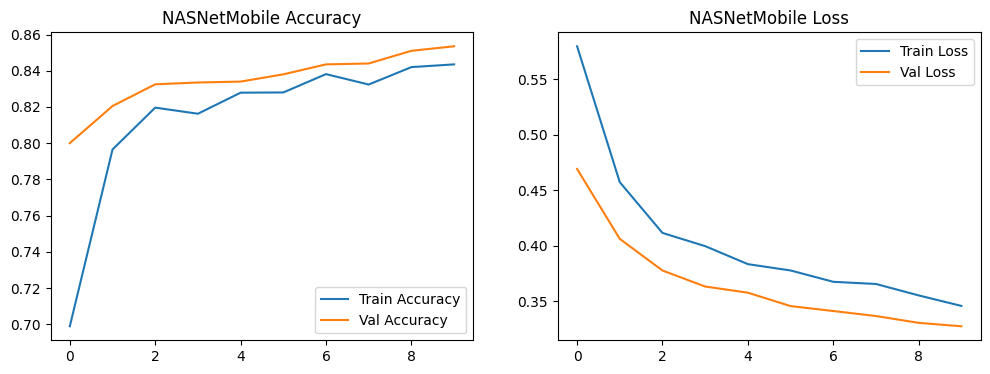

In [20]:
# Plot function for learning curves
def plot_learning_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.legend()

    plt.show()

# Display learning curves for each model
plot_learning_curves(densenet_history, 'DenseNet121')
plot_learning_curves(vgg_history, 'VGG16')
plot_learning_curves(nasnet_history, 'NASNetMobile')


#### Fine Tuning

In [51]:
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.optimizers import Nadam, Adam

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)

nasnet_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'recall'],)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('NASNet_fine_tuned_best_model.keras', monitor='val_accuracy', save_best_only=True)

history = nasnet_model.fit(train_gen, validation_data=test_gen, epochs=epochs, callbacks=[early_stopping, checkpoint])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8748 - loss: 0.2909 - recall: 0.8604 - val_accuracy: 0.8580 - val_loss: 0.3243 - val_recall: 0.8790
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.8767 - loss: 0.2914 - recall: 0.8608 - val_accuracy: 0.8605 - val_loss: 0.3170 - val_recall: 0.8600
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.8744 - loss: 0.2854 - recall: 0.8556 - val_accuracy: 0.8525 - val_loss: 0.3264 - val_recall: 0.8860
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8727 - loss: 0.2942 - recall: 0.8587 - val_accuracy: 0.8620 - val_loss: 0.3174 - val_recall: 0.8690
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.8734 - loss: 0.2956 - recall: 0.8534 - val_accuracy: 0.8625 - val_loss: 0.3178 - val_recall: 0.8760
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.8713 - loss: 0.2989 - recall: 0.8553 - val_accuracy: 0.8535 - val_loss: 0.3276 - val_recall:

#### Evaluation on separate Test Set

In [56]:
nasnet_model.evaluate(train_gen)

[0.199837827, 0.913333333, 0.9023898]
